# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

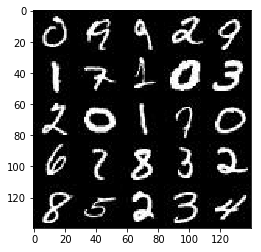

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

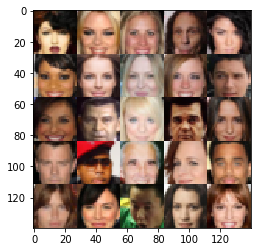

In [3]:
show_n_images = 31

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    fake = tf.placeholder(tf.float32, shape=(None, z_dim))
    lrn_rt   = tf.placeholder(tf.float32)

    return real, fake, lrn_rt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                             kernel_initializer = tf.random_normal_initializer(stddev=0.01))
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                             kernel_initializer = tf.random_normal_initializer(stddev=0.01))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding='same',
                             kernel_initializer = tf.random_normal_initializer(stddev=0.01))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param reuse: Parameter to specify if variables should be reused
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function  
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=5, strides=2, padding='same',
                                       kernel_initializer = tf.random_normal_initializer(stddev=0.01))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, filters=64, kernel_size=5, strides=2, padding='same',
                                       kernel_initializer = tf.random_normal_initializer(stddev=0.01))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(
            x3, filters=out_channel_dim, kernel_size=5, strides=1, 
            padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.01))
        # 28 x 28 x out_channel_dim 
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_real, 
            labels = tf.ones_like(d_logits_real)*(1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake, 
            labels = tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake, 
            labels = tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, alpha=0.1):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, alpha=alpha),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         alpha=0.1, smooth=0.1, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    :param alpha: leaky relu parameter
    :param smooth: "soft loss" smoothing parameter
    """
    # TODO: Build Model
    #tf.reset_default_graph()
        
    img_w = data_shape[1]
    img_h = data_shape[2]
    img_c = data_shape[3] # or coulud be: len(data_image_mode)
            
    # Get placeholders
    input_real, input_z, lrn_rt = model_inputs(img_w, img_h, img_c, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, img_c, alpha=alpha, smooth=smooth)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lrn_rt, beta1)

    # TODO: Train Model
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                batch_images = 2*batch_images
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lrn_rt: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lrn_rt: learning_rate})

                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, img_c, data_image_mode, alpha=alpha)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2259... Generator Loss: 2.2336
Epoch 1/2... Discriminator Loss: 0.6507... Generator Loss: 1.7495
Epoch 1/2... Discriminator Loss: 2.4906... Generator Loss: 4.2855
Epoch 1/2... Discriminator Loss: 3.7371... Generator Loss: 1.7187
Epoch 1/2... Discriminator Loss: 4.4728... Generator Loss: 2.3628
Epoch 1/2... Discriminator Loss: 1.8076... Generator Loss: 1.4304
Epoch 1/2... Discriminator Loss: 1.1412... Generator Loss: 0.7650
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 1.6008
Epoch 1/2... Discriminator Loss: 2.3082... Generator Loss: 0.1999
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 1.3441


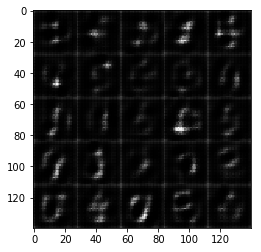

Epoch 1/2... Discriminator Loss: 1.7105... Generator Loss: 2.8692
Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 1.8769
Epoch 1/2... Discriminator Loss: 1.6869... Generator Loss: 0.7093
Epoch 1/2... Discriminator Loss: 1.7970... Generator Loss: 0.9678
Epoch 1/2... Discriminator Loss: 2.2229... Generator Loss: 1.3326
Epoch 1/2... Discriminator Loss: 1.2010... Generator Loss: 1.3945
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 0.7743
Epoch 1/2... Discriminator Loss: 1.6626... Generator Loss: 0.4012
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 1.3414
Epoch 1/2... Discriminator Loss: 2.1716... Generator Loss: 0.2059


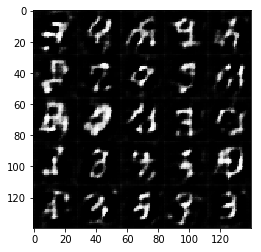

Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.5143
Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 0.6147
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 1.4869
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 1.0576
Epoch 1/2... Discriminator Loss: 1.2777... Generator Loss: 0.7374
Epoch 1/2... Discriminator Loss: 1.0379... Generator Loss: 1.3962
Epoch 1/2... Discriminator Loss: 1.3726... Generator Loss: 0.5226
Epoch 1/2... Discriminator Loss: 1.5975... Generator Loss: 0.4644
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 2.0115
Epoch 1/2... Discriminator Loss: 1.9508... Generator Loss: 0.2284


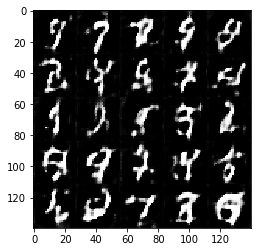

Epoch 1/2... Discriminator Loss: 1.1965... Generator Loss: 0.8735
Epoch 1/2... Discriminator Loss: 1.1190... Generator Loss: 1.9765
Epoch 1/2... Discriminator Loss: 1.0968... Generator Loss: 1.6795
Epoch 1/2... Discriminator Loss: 1.5053... Generator Loss: 0.5239
Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 0.6225
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 0.5820
Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 0.7298
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 1.5836
Epoch 1/2... Discriminator Loss: 1.7542... Generator Loss: 1.7322
Epoch 1/2... Discriminator Loss: 1.5240... Generator Loss: 0.3549


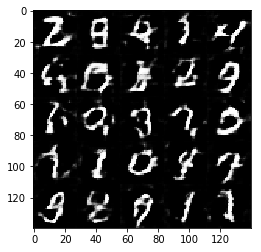

Epoch 1/2... Discriminator Loss: 1.5426... Generator Loss: 1.9319
Epoch 1/2... Discriminator Loss: 1.0766... Generator Loss: 0.9615
Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 1.6126
Epoch 1/2... Discriminator Loss: 1.1823... Generator Loss: 1.0314
Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 1.0756
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 0.4792
Epoch 2/2... Discriminator Loss: 1.8936... Generator Loss: 3.2905
Epoch 2/2... Discriminator Loss: 1.0364... Generator Loss: 0.8818
Epoch 2/2... Discriminator Loss: 1.3205... Generator Loss: 0.5073
Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 1.6393


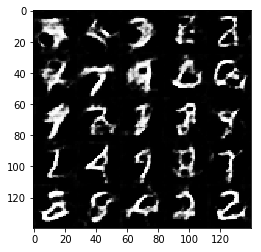

Epoch 2/2... Discriminator Loss: 1.1133... Generator Loss: 0.7178
Epoch 2/2... Discriminator Loss: 1.1744... Generator Loss: 0.6609
Epoch 2/2... Discriminator Loss: 1.2219... Generator Loss: 1.9114
Epoch 2/2... Discriminator Loss: 1.2724... Generator Loss: 0.7367
Epoch 2/2... Discriminator Loss: 1.1928... Generator Loss: 1.1868
Epoch 2/2... Discriminator Loss: 1.3448... Generator Loss: 2.0903
Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 2.1445
Epoch 2/2... Discriminator Loss: 1.3327... Generator Loss: 0.4711
Epoch 2/2... Discriminator Loss: 1.0463... Generator Loss: 1.0697
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 1.4337


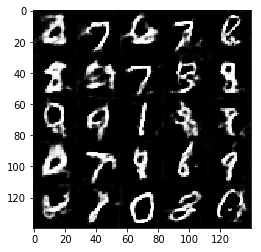

Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 1.1633
Epoch 2/2... Discriminator Loss: 1.2484... Generator Loss: 0.5878
Epoch 2/2... Discriminator Loss: 1.2811... Generator Loss: 1.5667
Epoch 2/2... Discriminator Loss: 1.2473... Generator Loss: 0.6897
Epoch 2/2... Discriminator Loss: 1.4661... Generator Loss: 0.3984
Epoch 2/2... Discriminator Loss: 1.1180... Generator Loss: 0.9810
Epoch 2/2... Discriminator Loss: 1.2194... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.4518... Generator Loss: 0.3954
Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 1.6703


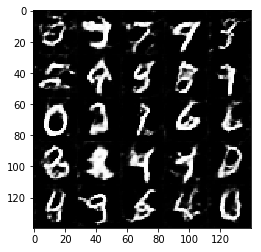

Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 0.8129
Epoch 2/2... Discriminator Loss: 1.0754... Generator Loss: 1.4117
Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 0.9458
Epoch 2/2... Discriminator Loss: 1.7348... Generator Loss: 0.3217
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.6556
Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 1.1863
Epoch 2/2... Discriminator Loss: 1.5933... Generator Loss: 2.1891
Epoch 2/2... Discriminator Loss: 1.0018... Generator Loss: 1.0986
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 1.1749
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.5582


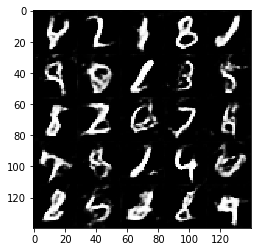

Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 0.8152
Epoch 2/2... Discriminator Loss: 1.5497... Generator Loss: 0.4024
Epoch 2/2... Discriminator Loss: 1.1193... Generator Loss: 0.7527
Epoch 2/2... Discriminator Loss: 1.1455... Generator Loss: 0.6170
Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 0.5977
Epoch 2/2... Discriminator Loss: 1.8815... Generator Loss: 0.3620
Epoch 2/2... Discriminator Loss: 1.1198... Generator Loss: 1.1283
Epoch 2/2... Discriminator Loss: 1.1807... Generator Loss: 0.6829
Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.5105
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 1.3261


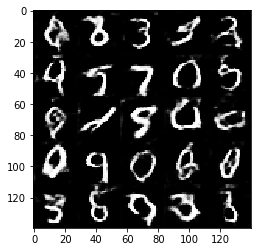

Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 0.8576
Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.4807
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 0.9245


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
alpha = 0.25
smooth = 0.0

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
            mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha, smooth=smooth)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 7.0234... Generator Loss: 1.6411
Epoch 1/1... Discriminator Loss: 4.8294... Generator Loss: 0.4170
Epoch 1/1... Discriminator Loss: 1.6922... Generator Loss: 13.4428
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 3.0231
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 5.2296
Epoch 1/1... Discriminator Loss: 1.7196... Generator Loss: 1.3742
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 5.5431
Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 5.4746
Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 3.4917
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 3.4902


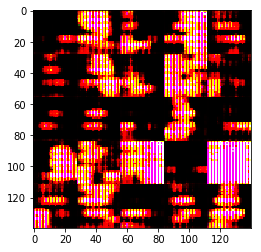

Epoch 1/1... Discriminator Loss: 0.4137... Generator Loss: 4.4829
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 4.0121
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 5.9231
Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 5.6184
Epoch 1/1... Discriminator Loss: 0.3579... Generator Loss: 7.1476
Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 6.3587
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 4.4643
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 3.7555
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 2.0449
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 2.6470


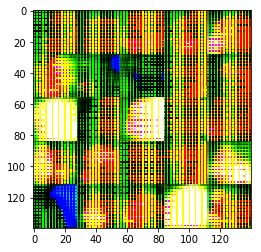

Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 5.6669
Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 3.4113
Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 3.0360
Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 4.0441
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 2.2466
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 2.7568
Epoch 1/1... Discriminator Loss: 4.9582... Generator Loss: 0.1266
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 3.5450
Epoch 1/1... Discriminator Loss: 0.3704... Generator Loss: 5.3027


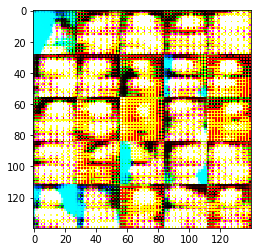

Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 5.2595
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 0.5403... Generator Loss: 2.2146
Epoch 1/1... Discriminator Loss: 0.4559... Generator Loss: 2.7518
Epoch 1/1... Discriminator Loss: 3.1789... Generator Loss: 5.5953
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 2.0377
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.4688
Epoch 1/1... Discriminator Loss: 3.0591... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 2.8148
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 2.6583


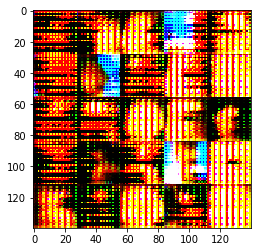

Epoch 1/1... Discriminator Loss: 0.4286... Generator Loss: 3.3212
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 3.0648
Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 4.0367
Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 5.9061
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.2063
Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 2.1426
Epoch 1/1... Discriminator Loss: 0.4436... Generator Loss: 2.9304
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 4.3314
Epoch 1/1... Discriminator Loss: 0.3682... Generator Loss: 5.1760
Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 3.3767


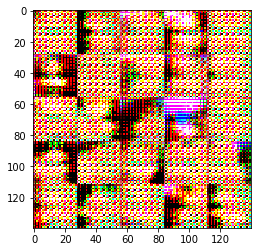

Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 5.4468
Epoch 1/1... Discriminator Loss: 0.3743... Generator Loss: 4.3041
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 5.2215
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 5.3135
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 4.2769
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 2.0104
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 4.3974
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 3.5768
Epoch 1/1... Discriminator Loss: 0.4180... Generator Loss: 3.2821
Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 2.7168


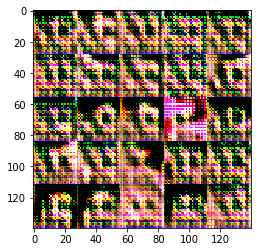

Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 6.9715
Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 6.8081
Epoch 1/1... Discriminator Loss: 0.3390... Generator Loss: 5.6065
Epoch 1/1... Discriminator Loss: 0.3698... Generator Loss: 8.2008
Epoch 1/1... Discriminator Loss: 0.3446... Generator Loss: 4.8382
Epoch 1/1... Discriminator Loss: 0.3399... Generator Loss: 15.5912
Epoch 1/1... Discriminator Loss: 11.0743... Generator Loss: 0.0141
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 2.0857
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 1.5584
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.3322


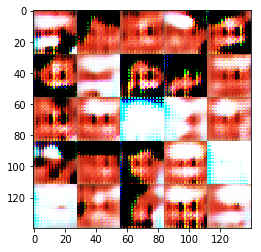

Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.5652
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 1.4344
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 2.5776
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 1.7334... Generator Loss: 2.2350
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 0.7152... Generator Loss: 1.8124
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 3.7531
Epoch 1/1... Discriminator Loss: 0.4746... Generator Loss: 3.0454
Epoch 1/1... Discriminator Loss: 1.7311... Generator Loss: 0.7105


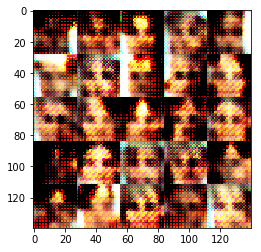

Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.4076
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.9744
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.1379
Epoch 1/1... Discriminator Loss: 2.5224... Generator Loss: 0.1796
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 2.4153
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 2.8631
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.7376


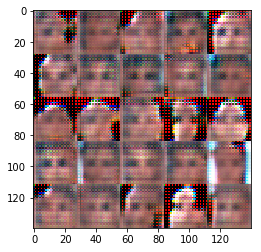

Epoch 1/1... Discriminator Loss: 1.6177... Generator Loss: 2.9032
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.5005
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.2741
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.5279
Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.4714
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 1.3765
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.0757


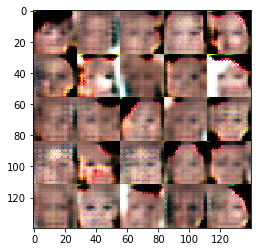

Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.3138
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 2.0324
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 2.4180
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 2.2384
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.0983
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 1.0091


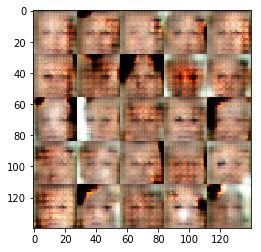

Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 1.6439
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.1275
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.3512


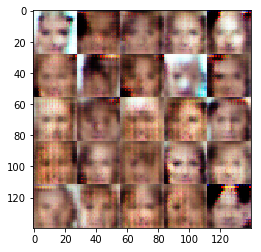

Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 1.2997
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 1.6275
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.3001


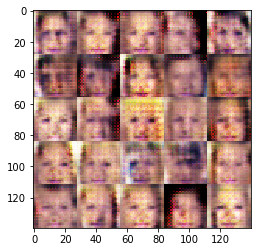

Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.3094
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 1.7161
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 3.1582
Epoch 1/1... Discriminator Loss: 2.1832... Generator Loss: 0.2150
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.2887


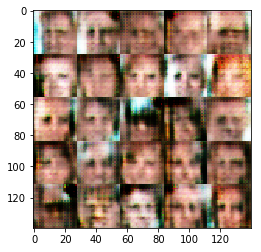

Epoch 1/1... Discriminator Loss: 1.5713... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 2.4544... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 1.3296
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 2.1873
Epoch 1/1... Discriminator Loss: 0.5345... Generator Loss: 2.1634
Epoch 1/1... Discriminator Loss: 0.4359... Generator Loss: 2.9164
Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 2.4570
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 2.7496
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 2.5656
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.7776


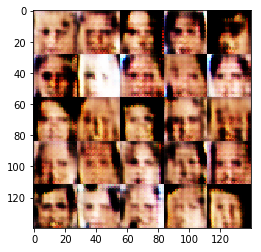

Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 1.4226
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 1.5393
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 3.2906
Epoch 1/1... Discriminator Loss: 0.6213... Generator Loss: 9.3767
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 3.7725


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.01
beta1 = 0.5
alpha=0.1
smooth=0


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.